# Integrantes do grupo:
# Andreza Lukosiunas - @andrezasp (nusp: 7157922)
# Juliano Garcia - @robotenique (nusp: 9277086)
# Pedro Carvalho - @pHrfo (nusp: 11376164)

In [13]:
# Pacotes utilizados

# Conectar-se ao Drive
from google.colab import drive

# https://docs.python.org/3/library/os.html
import os

# https://matplotlib.org/
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# https://pandas.pydata.org/
import pandas as pd

# https://numpy.org/
import numpy as np

# https://docs.python.org/3/library/itertools.html
import itertools

# https://pypi.org/project/Pillow/
from PIL import Image

# skimage para carregar as imagens
# https://scikit-image.org/
import skimage
from skimage import data
from skimage.morphology import disk, ball
from skimage.filters.rank import gradient, median
from skimage import filters
# https://scikit-image.org/docs/dev/api/skimage.io.html
from skimage import io

# https://pypi.org/project/opencv-python/
import cv2

# https://pypi.org/project/tqdm/
# from tqdm import tqdm
from tqdm.notebook import tqdm

# https://docs.python.org/3/library/shutil.html
import shutil

# https://docs.python.org/3/library/pathlib.html
from pathlib import Path

# https://docs.python.org/3/library/glob.html
import glob

# https://docs.python.org/3/library/collections.html
from collections import Counter

# https://docs.python.org/3/library/math.html
import math

In [14]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Diretório do trabalho no drive

In [15]:
os.chdir('/content/gdrive/My Drive/MAC5768 - Visão computacional/')

# EP2
## Nas primeiras células temos as declarações das funções
## Nas últimas, a parte que as usa em: Main - Roda tudo!

## EP2 - Parte 2 | Análise da variação das classes

## Função para normalização com equalizador (está na parte 1)

## Funções para o protótipo de média e plotagem

In [16]:
# Auxiliar para a escolher uma classe
def let_user_pick(options):
    print("Qual classe você quer visualizar?")
    for idx, element in enumerate(options):
        print("{}) {}".format(idx+1,element))
    i = input("Coloque o número: ")
    try:
        if 0 < int(i) <= len(options):
            return int(i)
    except:
        pass
    return None

In [17]:
# Testar com algumas imagens - tem que fazer para todas os folders
# Testar com algumas imagens
def create_img_proto(run=False):
  if run:
    proto_mean = []
    proto_name = []
    files_proto = metadados2[metadados2.repeticao == 1]
    classes = files_proto.classe.unique()
    dict_folders = {'originalGrayDataset': 'gray', 'augmentedDataset': 'convertida', 'normalizedDataset': 'normalizada'}

    for folder in tqdm(dict_folders):
      for classe in classes:
        imgs = []
        files_proto_aux = files_proto[files_proto.classe == classe]
        ini = True
        for file in set(files_proto_aux[dict_folders[folder]]):
          # exclui a imagem gradiente
          if '_grad' not in file:
            img = mpimg.imread(folder + "/" + file)
            # Resize imagem caso necessário
            if ini:
                height = img.shape[0]
                width = img.shape[1]
                ini = False
            else:
                img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
                # img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_NEAREST)
            # Apenda as imagens
            imgs.append(img)  
        # Média das imagens
        proto_mean.append(np.mean(np.array(imgs), axis=0, dtype=np.int))
        proto_name.append(folder + " - " + classe)
    return proto_mean, proto_name

# Plota as imagens do protótipo médio
def plot_img_proto(proto_mean, proto_name, run=False):
  if run:
    num_col = 6
    num_row = math.ceil(len(proto_mean)/num_col)
    i = 0
    j = 0

    fig, axes = plt.subplots(num_row, num_col, figsize=(50, 30))
    for img, label in zip(proto_mean, proto_name):
      if num_row == 1:
        ax = axes[j]
      else:  
        ax = axes[i, j]
      ax.imshow(img, aspect='equal', cmap=plt.cm.gray)
      ax.set_title(label, fontsize=20)
      ax.set_axis_off()
      j = j + 1
      if j == num_col:
        j = 0
        i = i + 1

    #fig.subplots_adjust(wspace=0, hspace=0)
    fig.show()

## Funções para Histograma Médio e plotagem

In [18]:
# Computa o histograma médio das imagens de uma classe
def resize_image(img):
  height = int(img.shape[0] * 0.7)
  width = int(img.shape[1] * 0.7)
  im_resized = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
  return im_resized

def mean_histogram(metadados, folder, classe, compute_sd=True, no_excgrad=False):
  # # Escolha da classe
  # options = metadados.classe.unique()
  # class_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  # class_dict = dict(zip(class_id, options))
  # answer = let_user_pick(options)
  # classe = class_dict[answer]

  dict_folders = {'originalGrayDataset': 'gray', 'augmentedDataset': 'convertida', 'normalizedDataset': 'normalizada'}

  dataset = metadados[metadados.classe == classe]
  histograms = []
  sd_array = []
  # Iteramos pelos arquivos, abrindo cada um com o mpimg como array 1D
  for f in tqdm(set(dataset[dict_folders[folder]]), position=0, leave=True):
    
    # Verifica se queremos ignorar a aplicaçao do gradiente (será explicado 
    # mais a frente)
    if no_excgrad and "_excgrad" in f:
      continue
    # exclui a imagem gradiente
    if '_grad' not in f:
      img = mpimg.imread(folder + "/" + f)
      img = resize_image(img)
      img = img.flatten()

      # Calcula o numero de ocorrencias de cada valor no array da imagem
      counter = Counter(img)
      histogram_list = np.zeros(256)
      for val in counter:
        histogram_list[val] += counter[val]
      histograms.append(np.array(histogram_list))
  # Calcula a média de ocorrencias dos valores de intensidade
  mean_histogram = np.sum(histograms, axis=0)/len(histograms)

  if compute_sd:
    for intensity in range(256):
      sd_array += [np.std(np.array(histograms)[:,intensity])]
  print()
  return mean_histogram, sd_array if compute_sd else mean_histogram


def plot_mean_histogram(classe, histogram, sd=None, sd_mult=1):
  plt.figure(figsize=(15,10))
  plt.title(classe, fontsize=30)
  plt.plot(histogram, label="Histograma")

  if sd is not None:
    sd_top = [hist_val + sd_mult*sd_val for hist_val, sd_val in zip(histogram, sd)]
    sd_bottom = [hist_val - sd_mult*sd_val for hist_val, sd_val in zip(histogram, sd)]
    plt.plot(sd_top, label=f"+{sd_mult} * Desvio Padrão")
    plt.plot(sd_bottom, label=f"- {sd_mult} * Desvio Padrão")
  plt.legend()


  

# Main - Roda tudo!

## Metadados Inicial

In [19]:
metadados = pd.read_csv('metadados/metadados.csv', encoding='utf-8', delimiter=",", index_col=0)

In [20]:
metadados.head()

arquivo  classe       objecto  ...    local  resolucao    tamanho
0     20210417_153013.jpg  óculos  óculos gucci  ...  interno  2560x1440  1144814.0
1  20210417_153014(0).jpg  óculos  óculos gucci  ...  interno  2560x1440  1128321.0
2     20210417_153014.jpg  óculos  óculos gucci  ...  interno  2560x1440  1118719.0
3  20210417_153025(0).jpg  óculos   óculos dior  ...  interno  2560x1440  1084526.0
4     20210417_153025.jpg  óculos   óculos dior  ...  interno  2560x1440  1135350.0

[5 rows x 9 columns]

## Carrega os novos metadados e faz o merge

In [21]:
# Carrega os dados
metadados_originalGrayDataset = pd.read_csv('metadados/metadados_originalGrayDataset.csv', encoding='utf-8', delimiter=",", index_col=0)
metadados_augmentedDataset = pd.read_csv('metadados/metadados_augmentedDataset.csv', encoding='utf-8', delimiter=",", index_col=0)
metadados_normalizedDataset = pd.read_csv('metadados/metadados_normalizedDataset.csv', encoding='utf-8', delimiter=",", index_col=0)
metadados_originalGrayDataset = metadados_originalGrayDataset.rename(columns={'convertida': 'gray'})

# Cruza o metadados com novos metadados provenientes das novas imagens
metadados2 = pd.merge(metadados,metadados_augmentedDataset,left_on=['arquivo'],right_on=['arquivo'])
metadados2 = pd.merge(metadados2,metadados_normalizedDataset,left_on=['convertida'],right_on=['convertida'])
metadados2 = pd.merge(metadados2,metadados_originalGrayDataset,left_on=['arquivo'],right_on=['arquivo'])

In [22]:
metadados2.head()

arquivo  ...                       gray
0  20210417_153013.jpg  ...  20210417_153013_gray2.jpg
1  20210417_153013.jpg  ...  20210417_153013_gray2.jpg
2  20210417_153013.jpg  ...  20210417_153013_gray2.jpg
3  20210417_153013.jpg  ...  20210417_153013_gray2.jpg
4  20210417_153013.jpg  ...  20210417_153013_gray2.jpg

[5 rows x 12 columns]

## Plota imagens filtradas e os protótipos da média

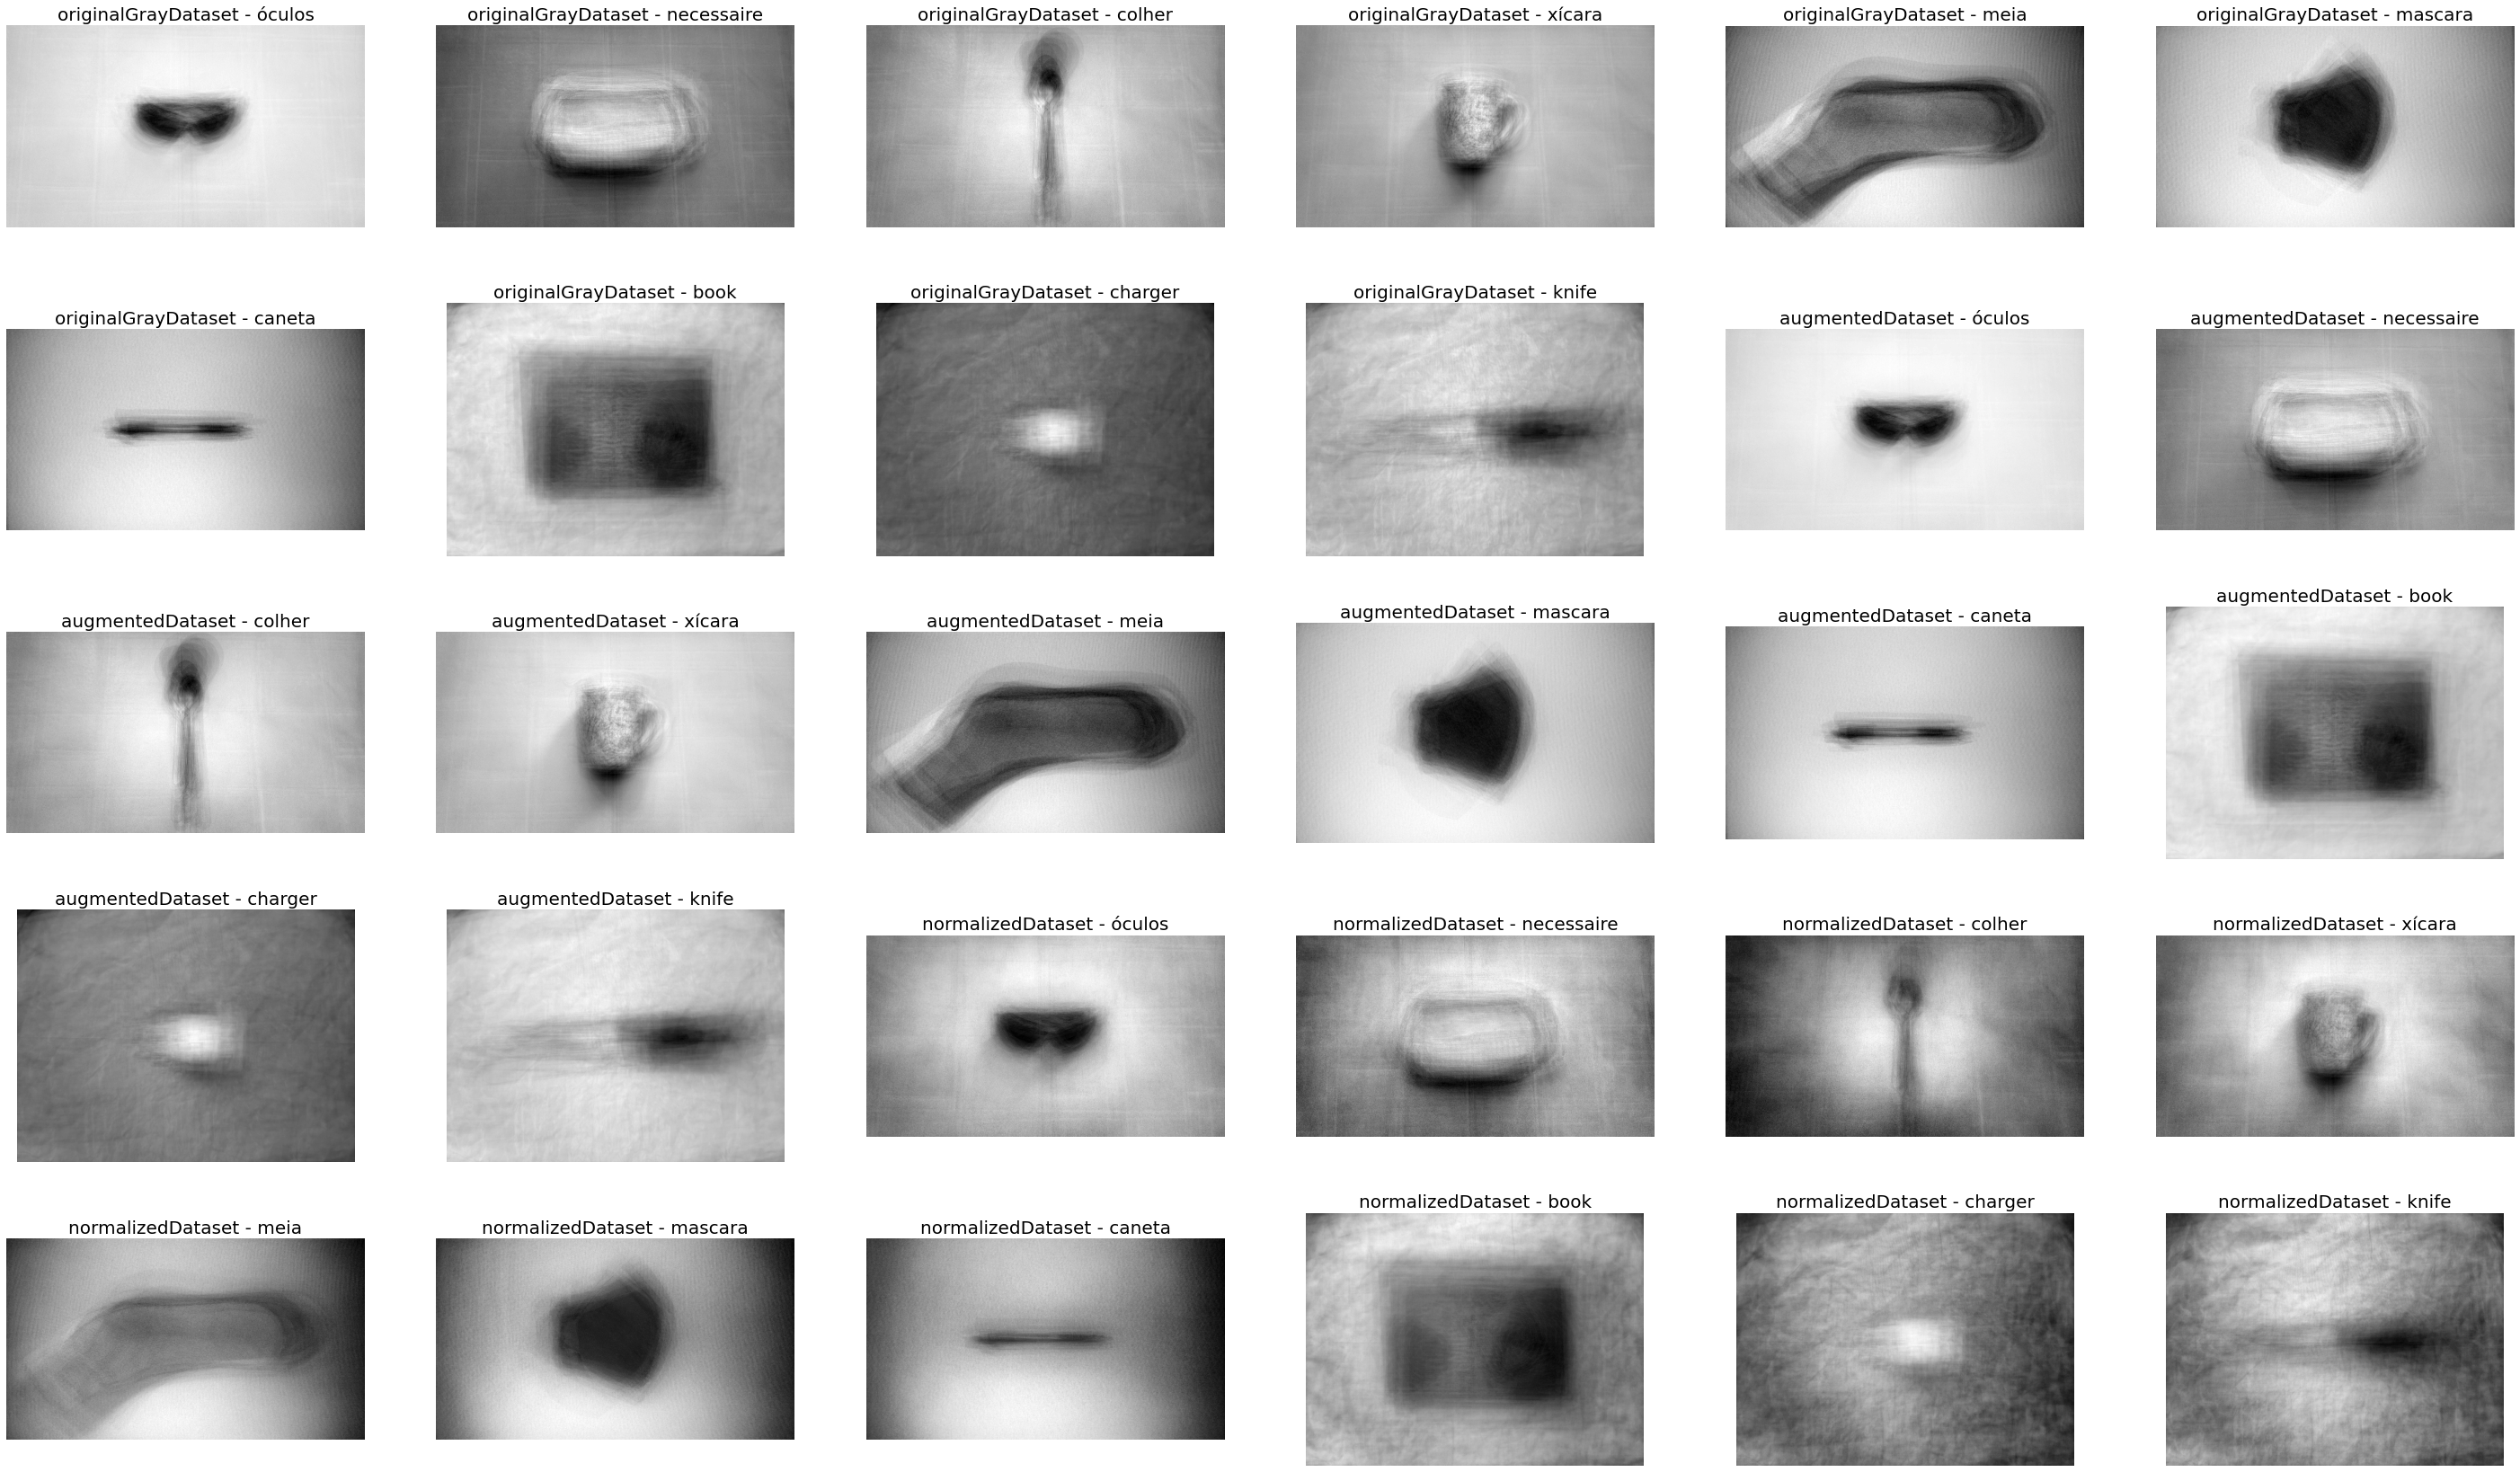

In [ ]:
# Plota imagens do protótipo da média - Rodar essas duas funções juntas, pois as imagens do protótipo não serão salvas
proto_mean, proto_name = create_img_proto(run=True)
plot_img_proto(proto_mean, proto_name, run=True)

## Roda o histograma com variância para os folders originalGrayDataset, augmentedDataset, convertida, normalizedDataset. Uma classe apenas será escolhida

In [23]:
# Array com classes para os histogramas 
classes = metadados2['classe'].unique()

óculos




necessaire




colher




xícara




meia




mascara




caneta




book




charger




knife


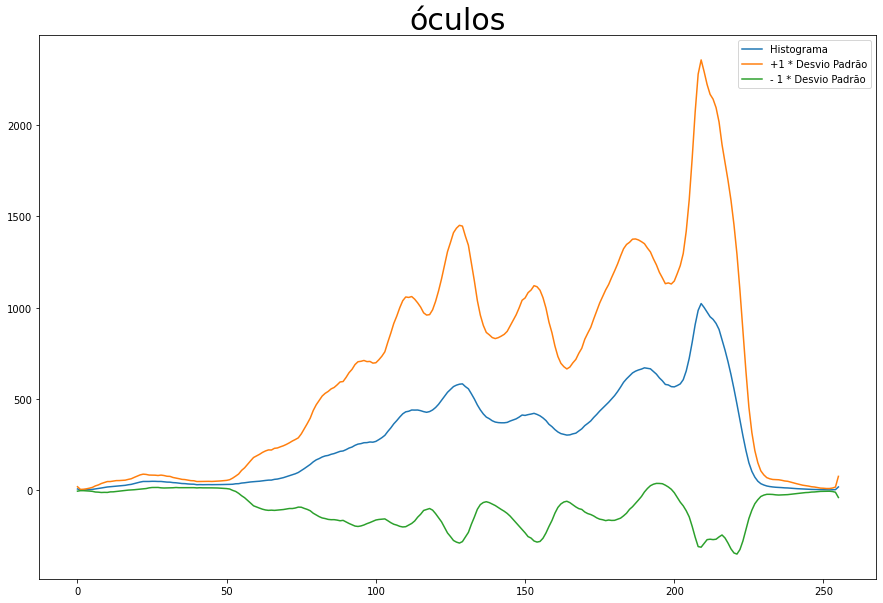

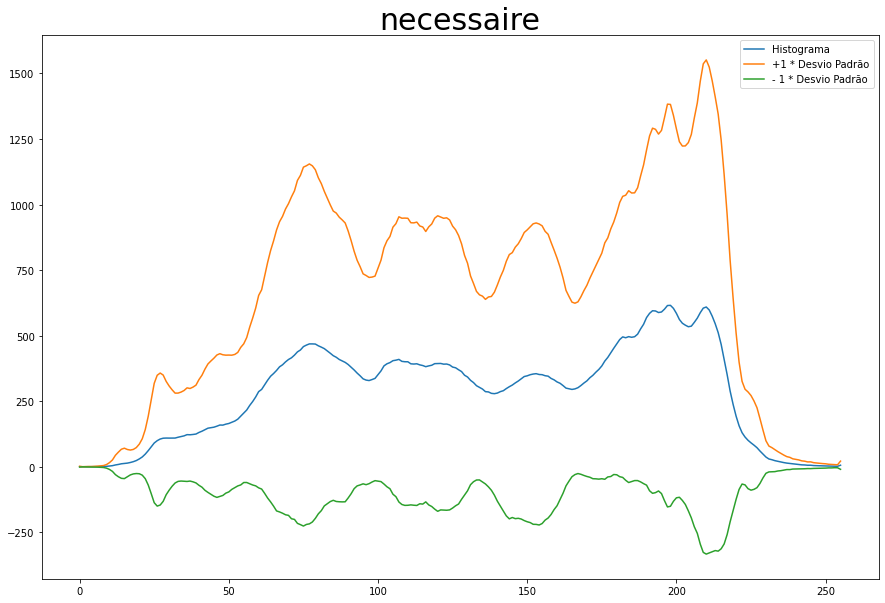

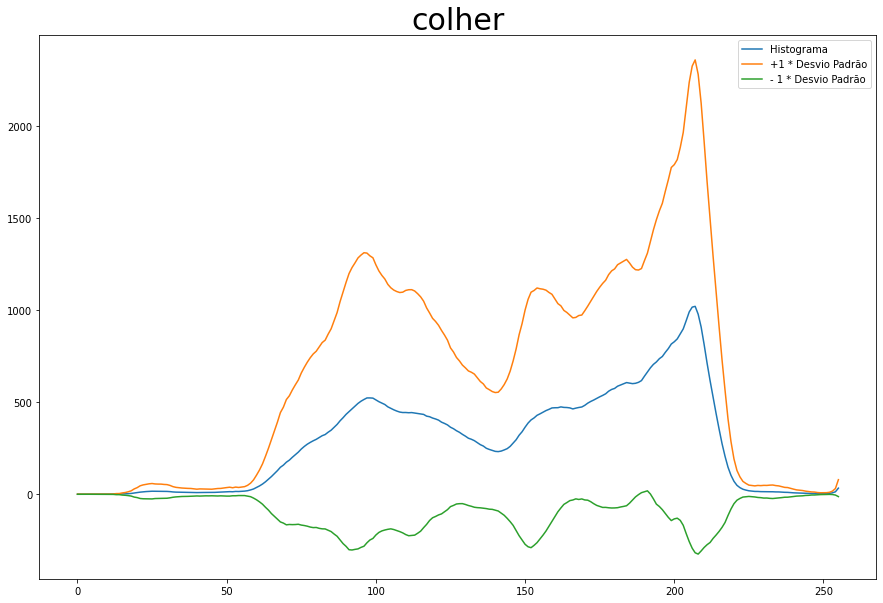

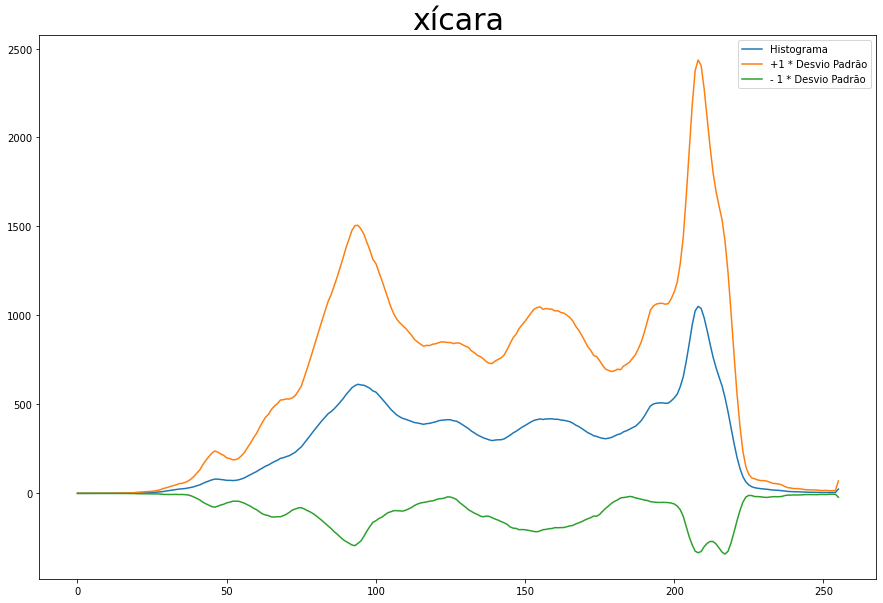

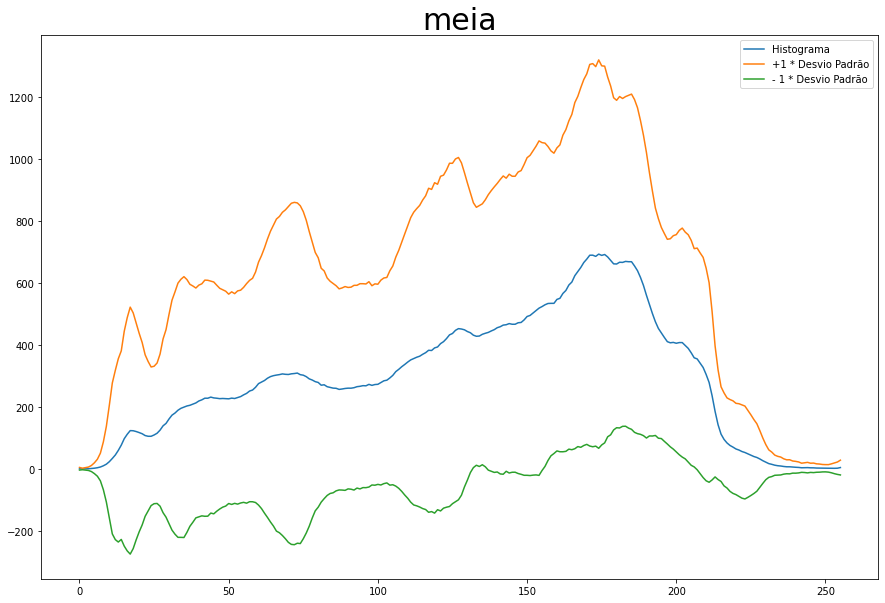

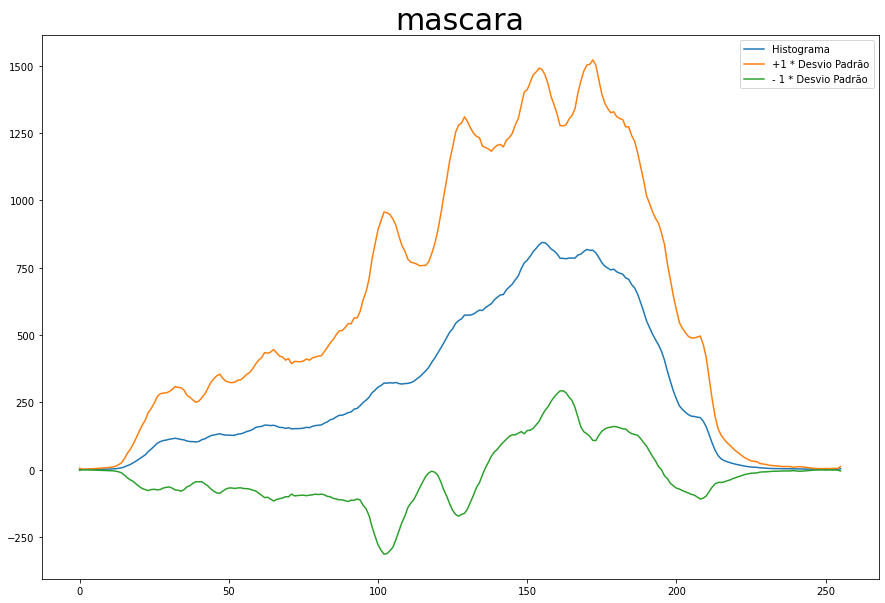

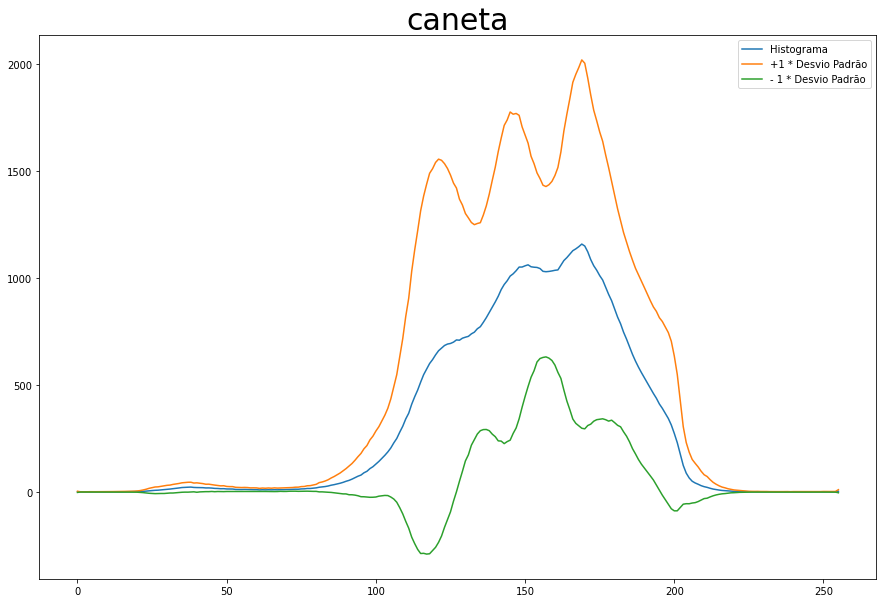

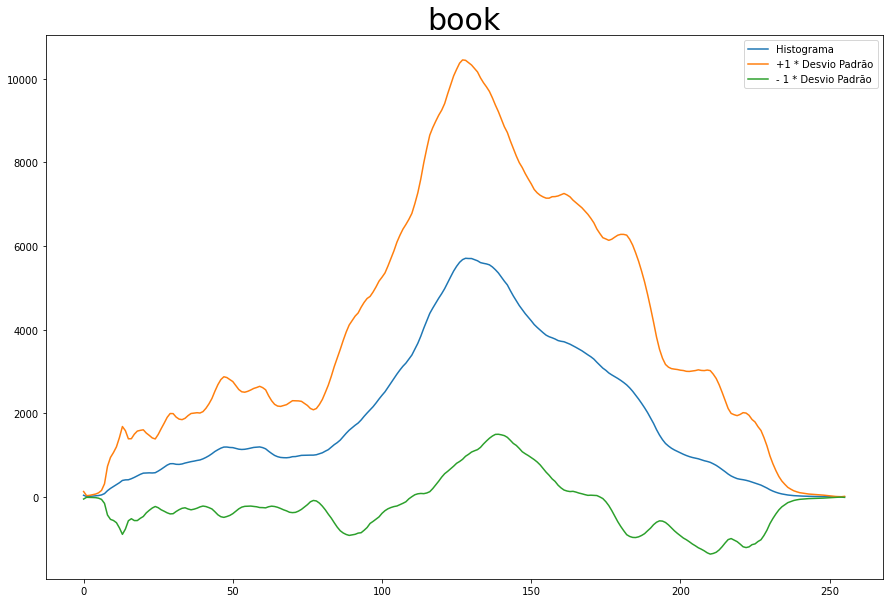

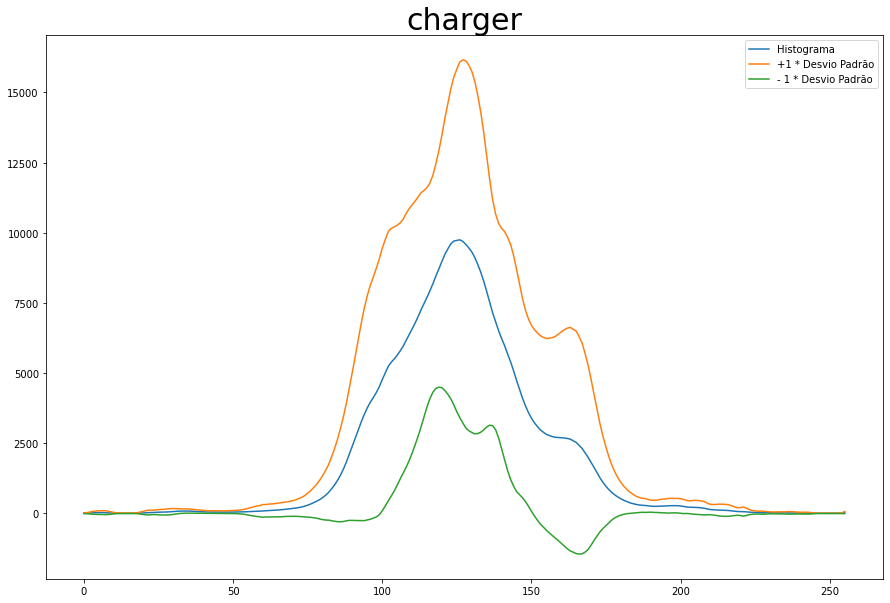

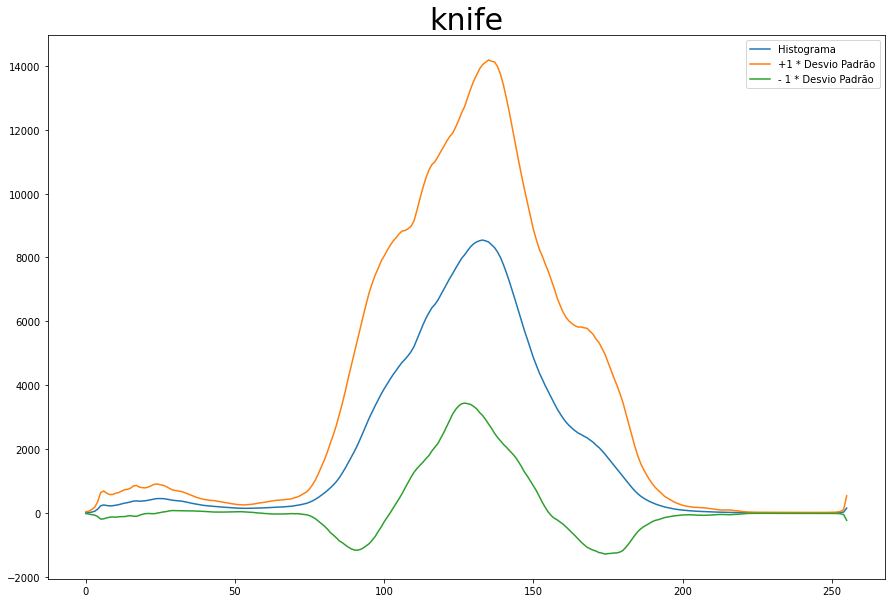

In [ ]:
# Para folder originalGrayDataset
for classe in classes:
  print(classe)
  histogram, sd = mean_histogram(metadados2, 'originalGrayDataset', classe)
  plot_mean_histogram(classe, histogram, sd, sd_mult=1)

Aqui tem um ponto importante: Nas imagens excgrad (imagens da composição da imagem gradiente com a original), do augmented dataset, há uma GRANDE quantidade de pixels em 255. Nesse caso os histogramas ficam como o abaixo:

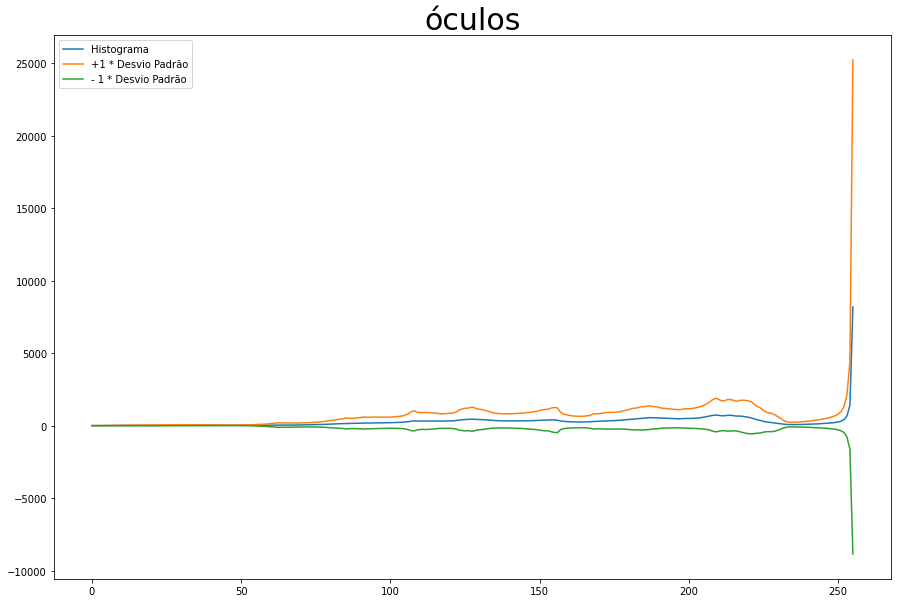

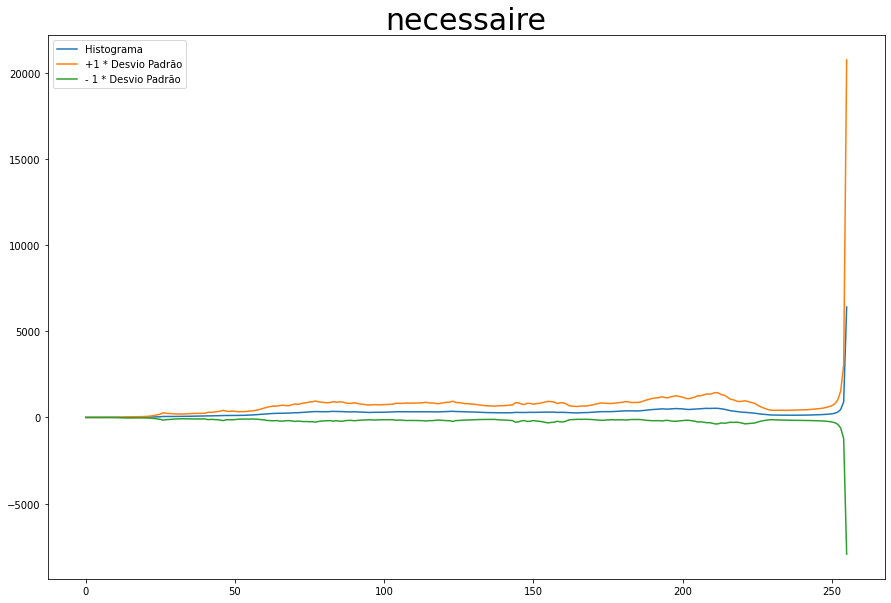

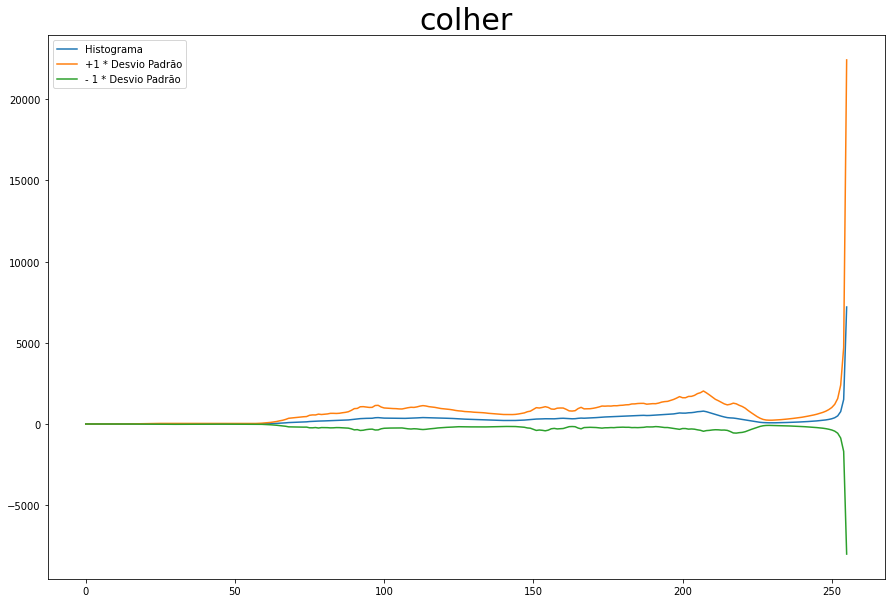

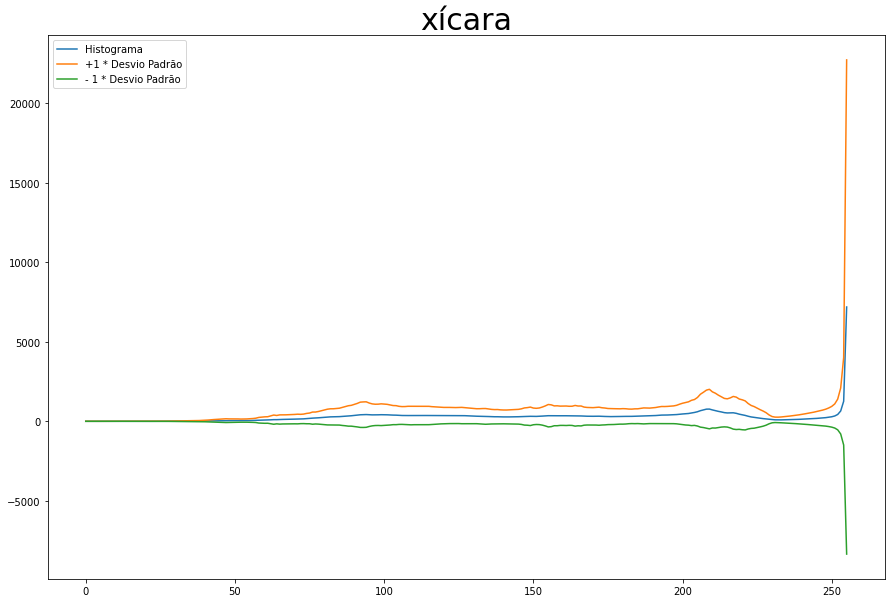

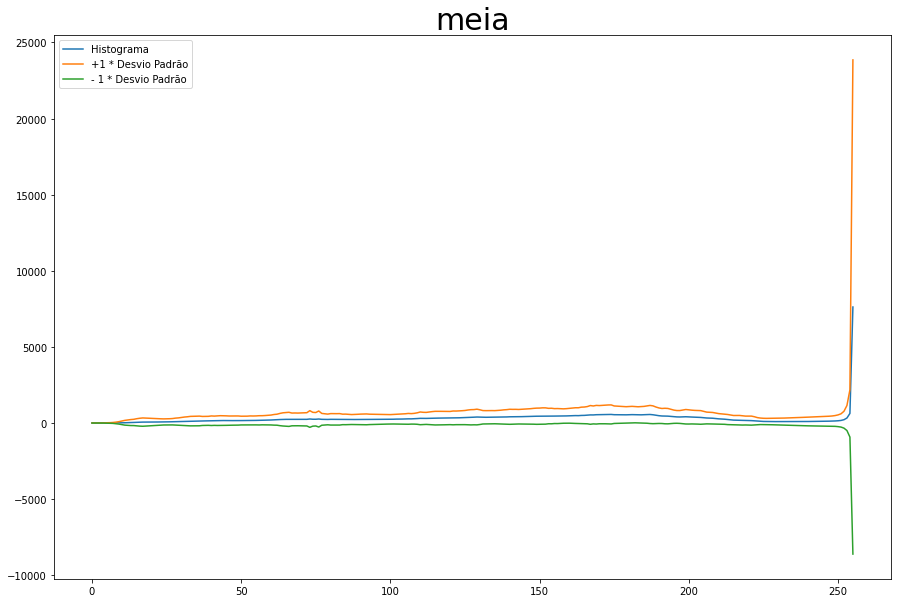

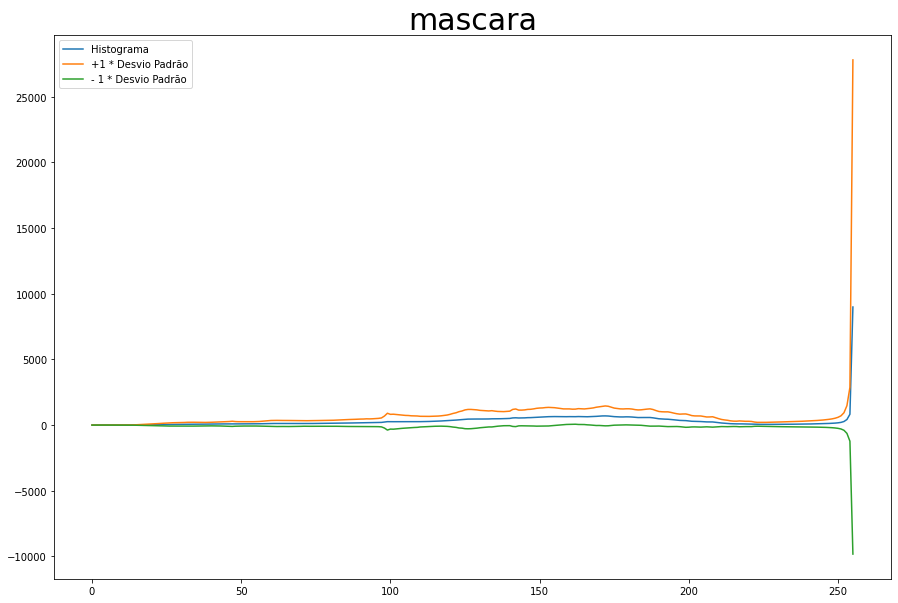

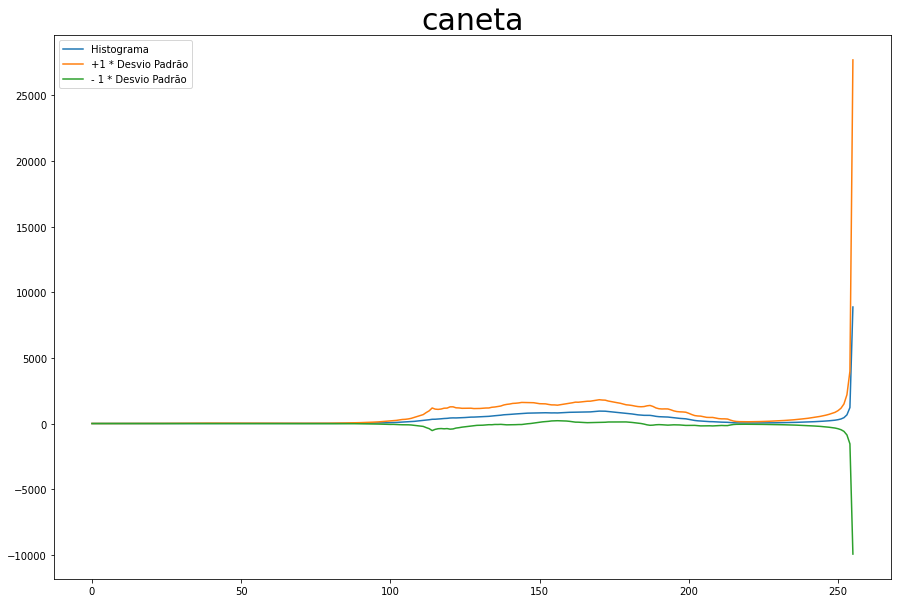

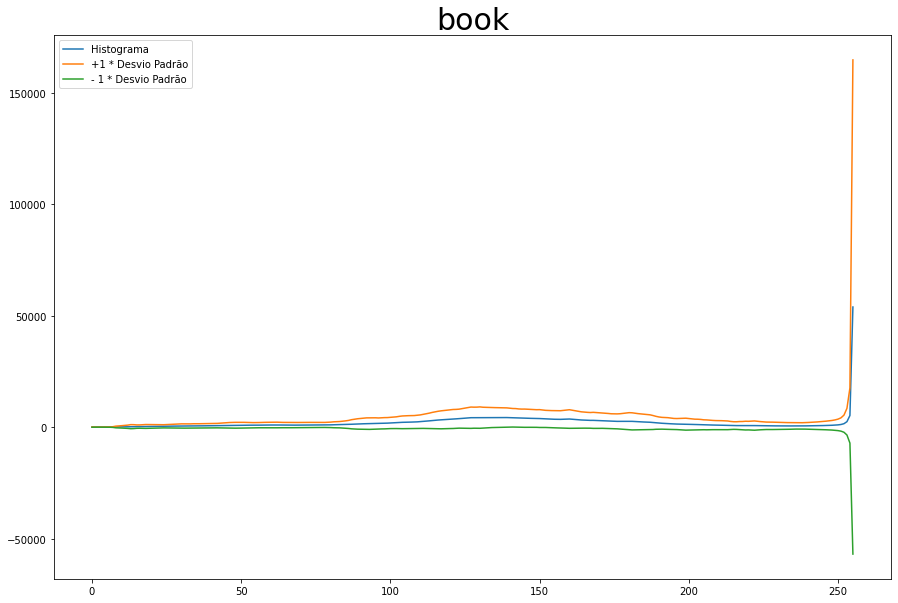

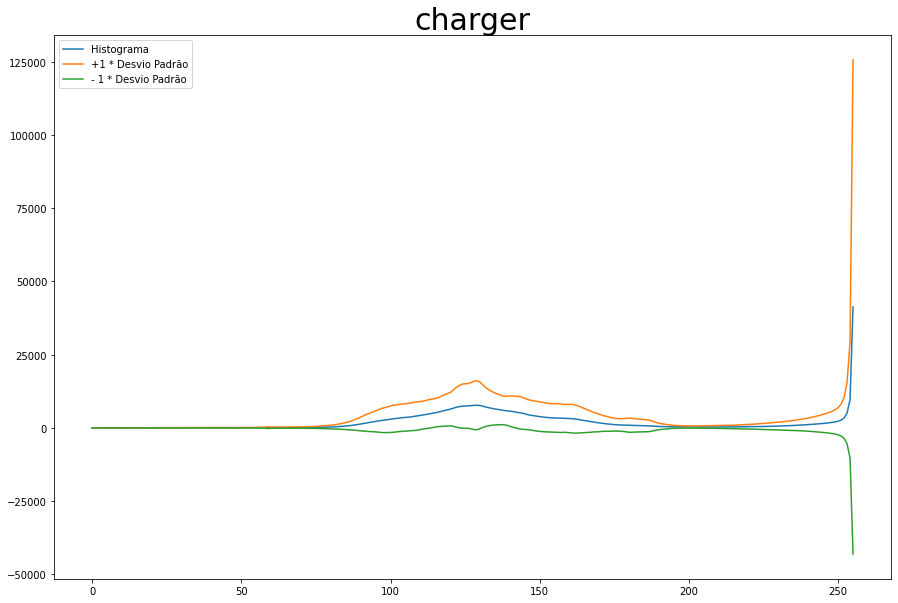

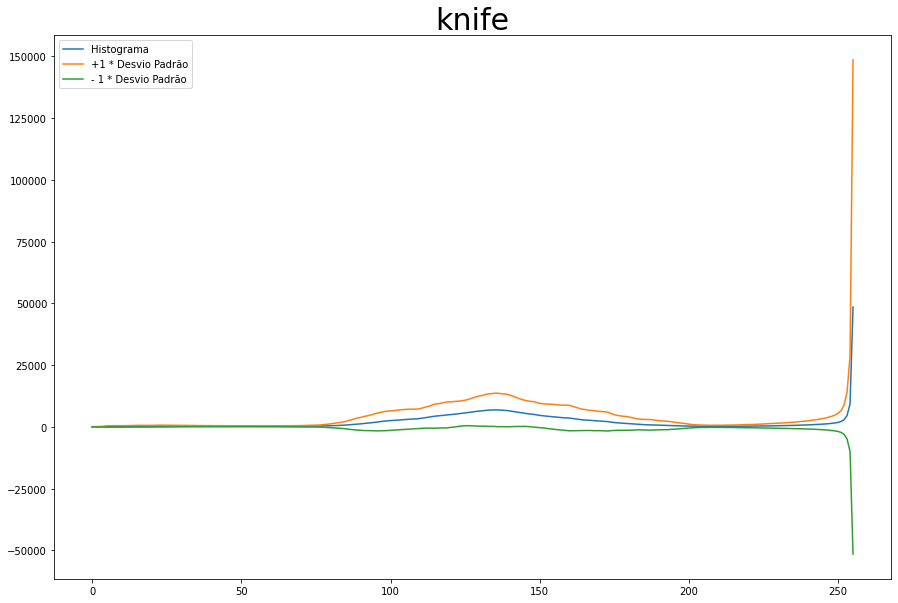

In [24]:
for classe in classes:
  histogram, sd = mean_histogram(metadados2, 'augmentedDataset', classe)
  plot_mean_histogram(classe, histogram, sd, sd_mult=1)

Para não ficar com esse pico no 255, estamos removendo as imagens excgrad da contagem do histograma médio. Para isso, há o parametro no_excgrad

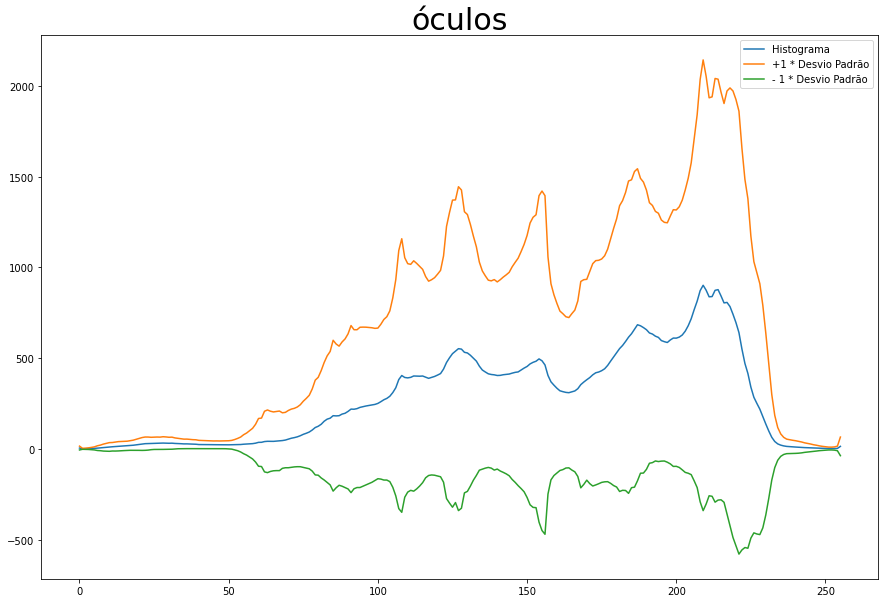

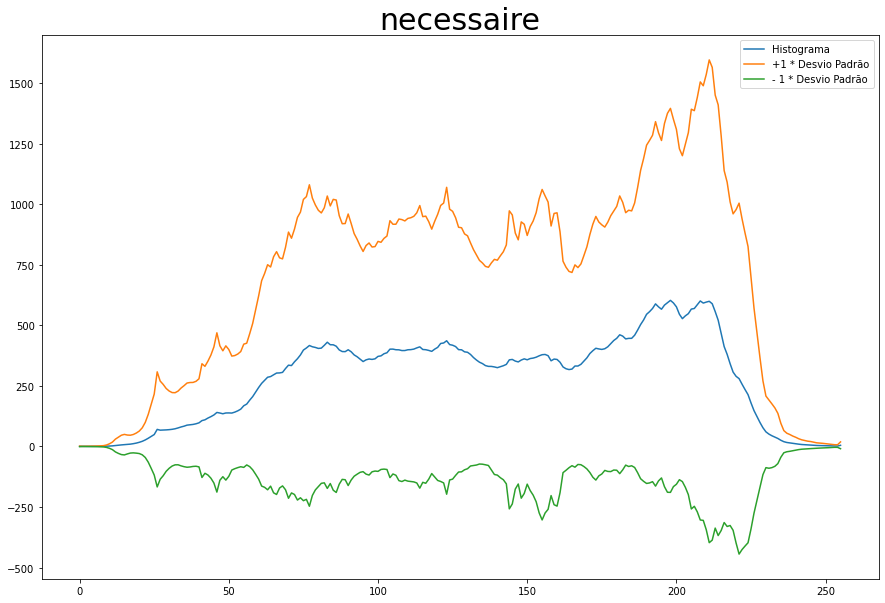

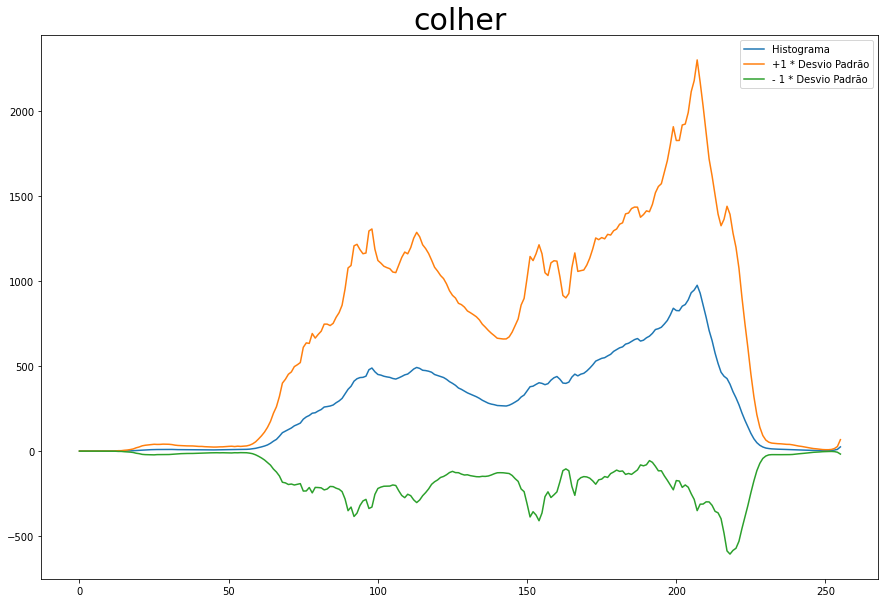

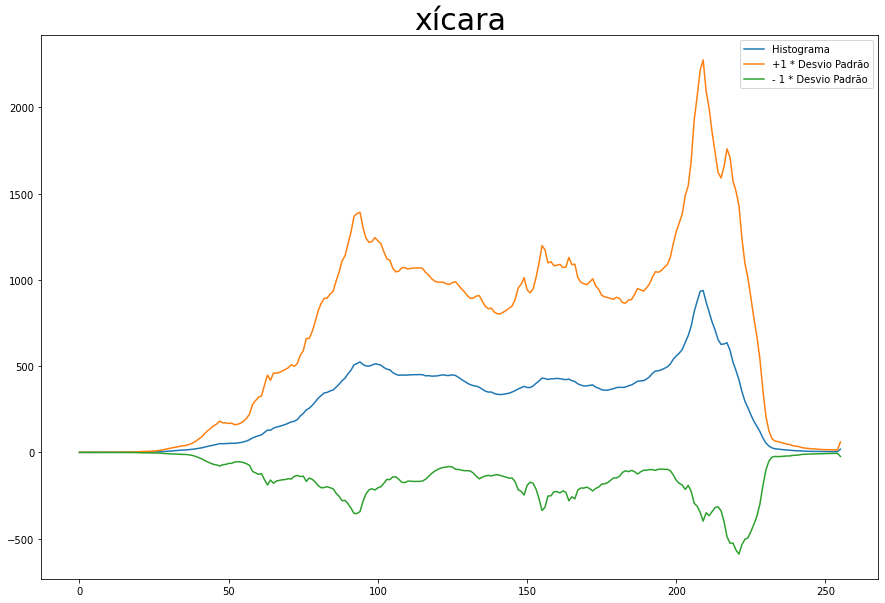

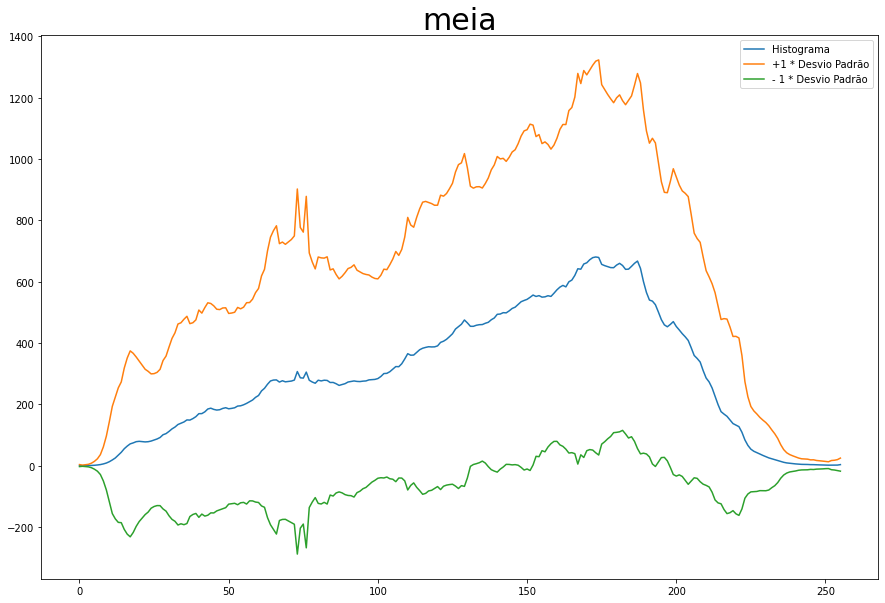

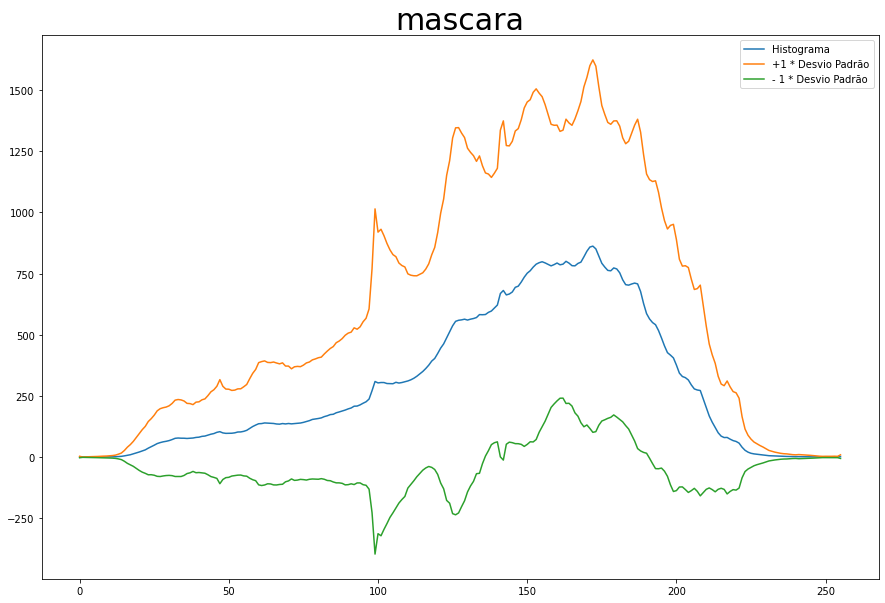

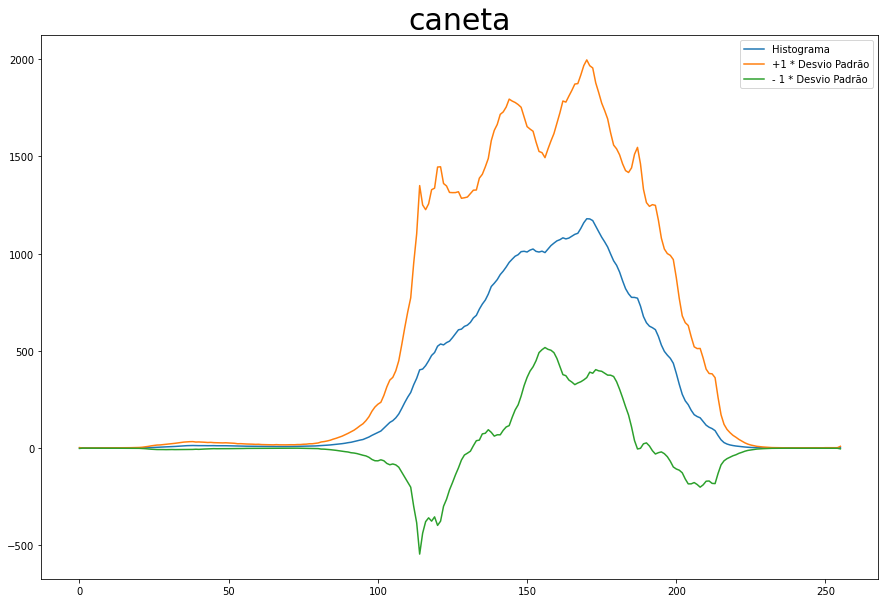

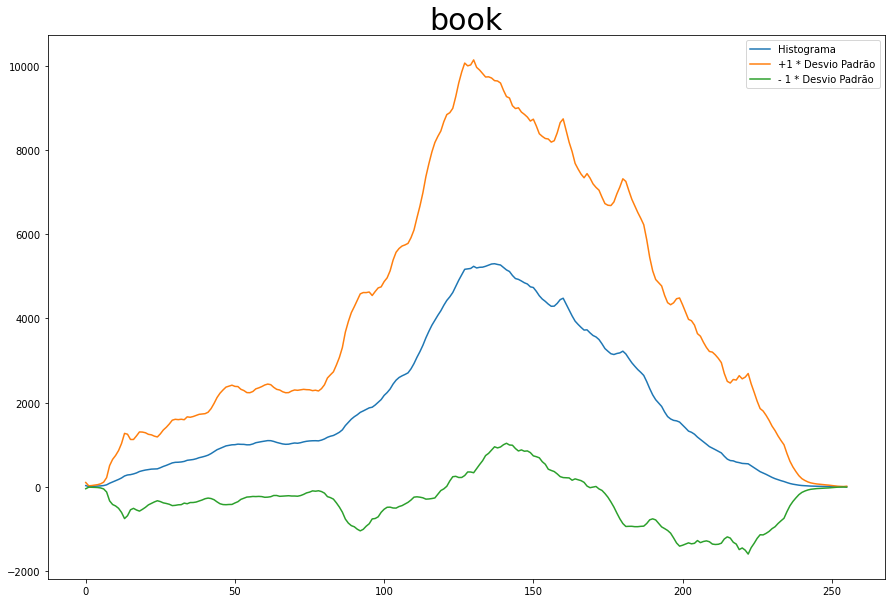

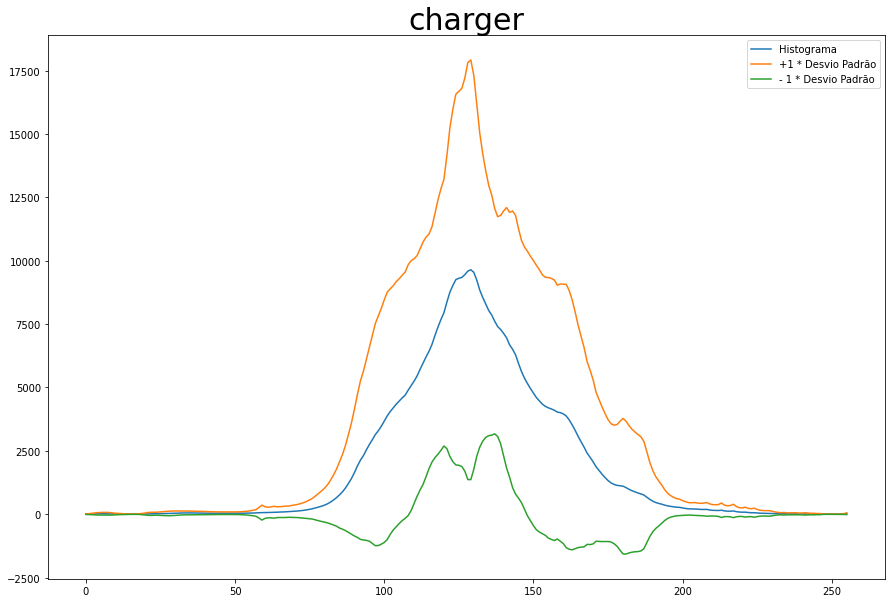

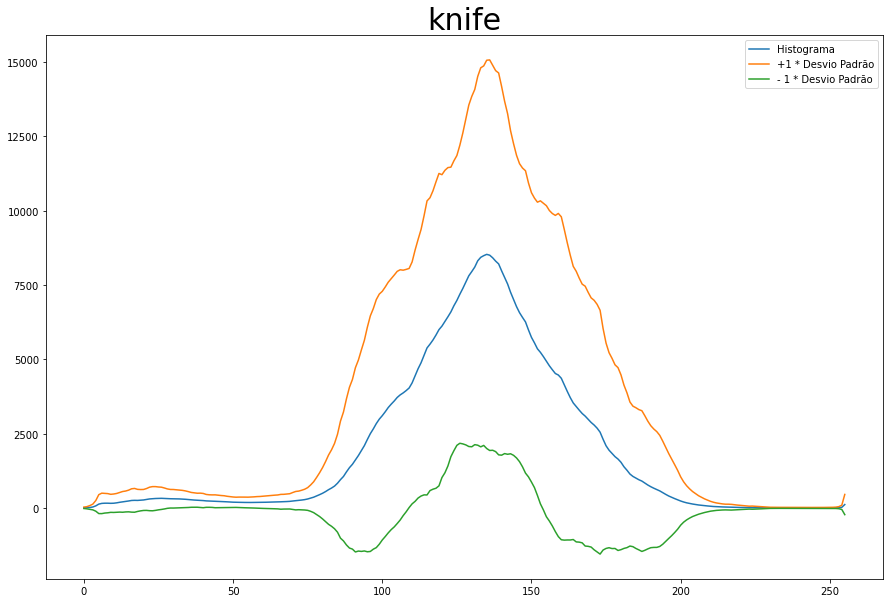

In [ ]:
# para folder augmentedDataset
for classe in classes:
  histogram, sd = mean_histogram(metadados2, 'augmentedDataset', classe, no_excgrad=True)
  plot_mean_histogram(classe, histogram, sd, sd_mult=1)

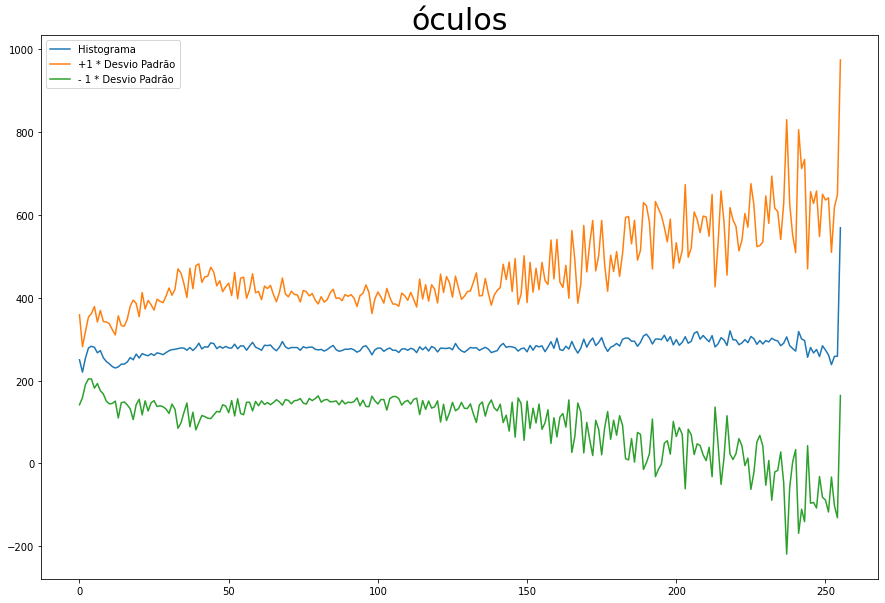

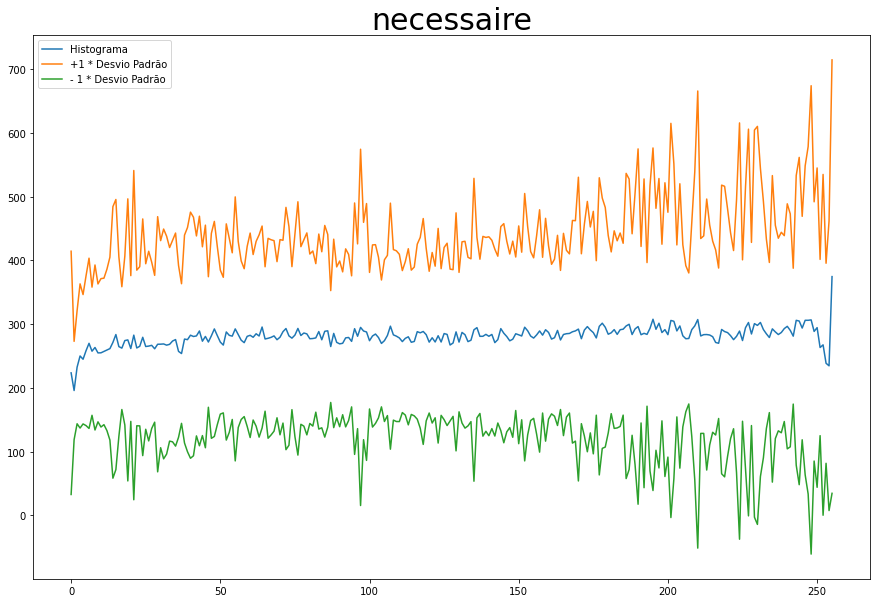

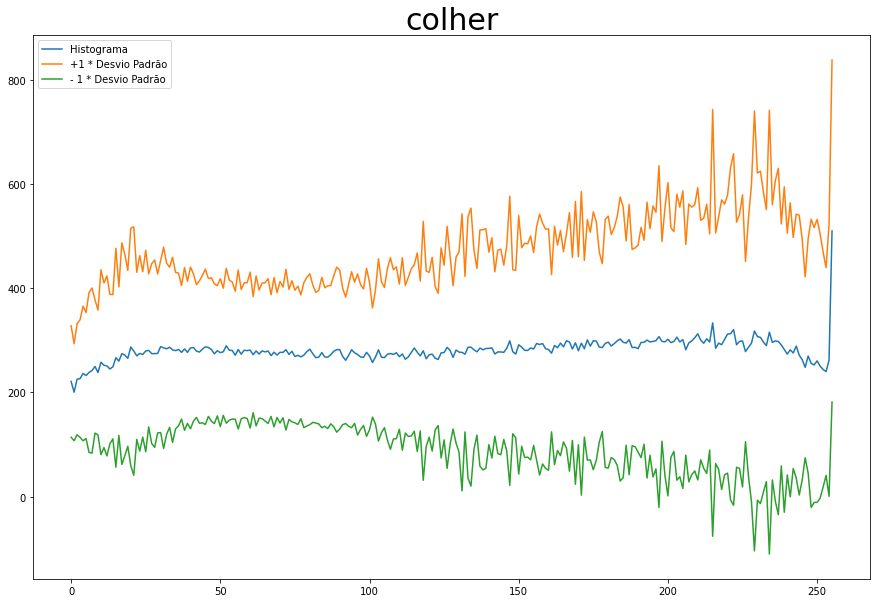

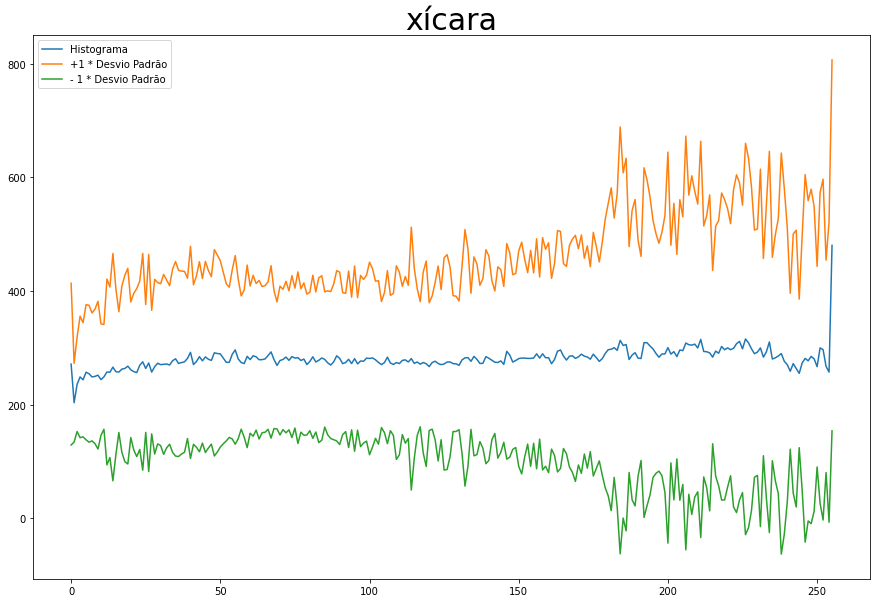

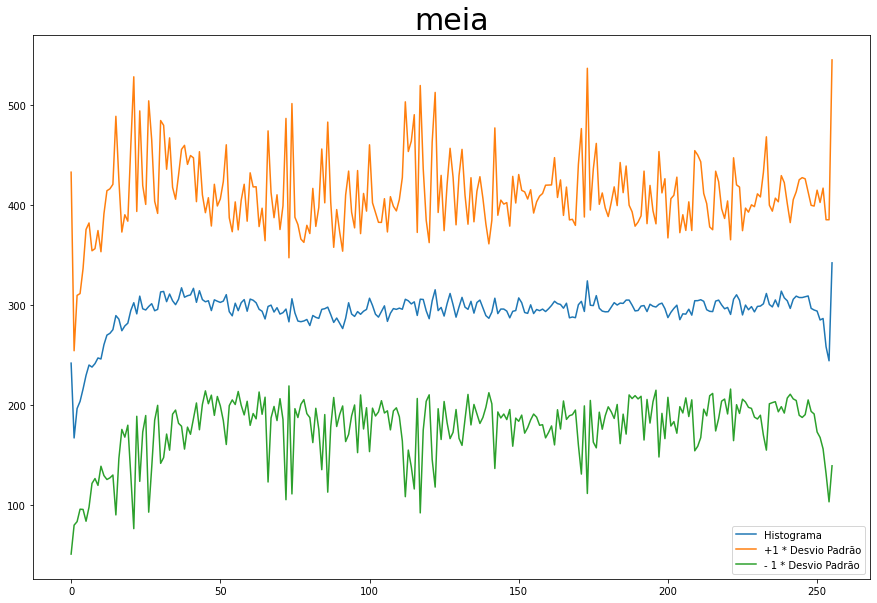

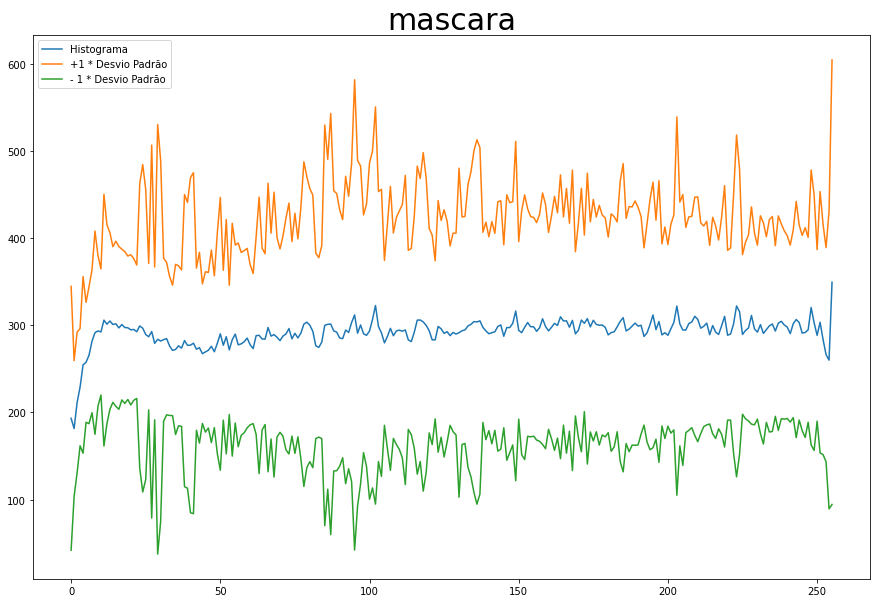

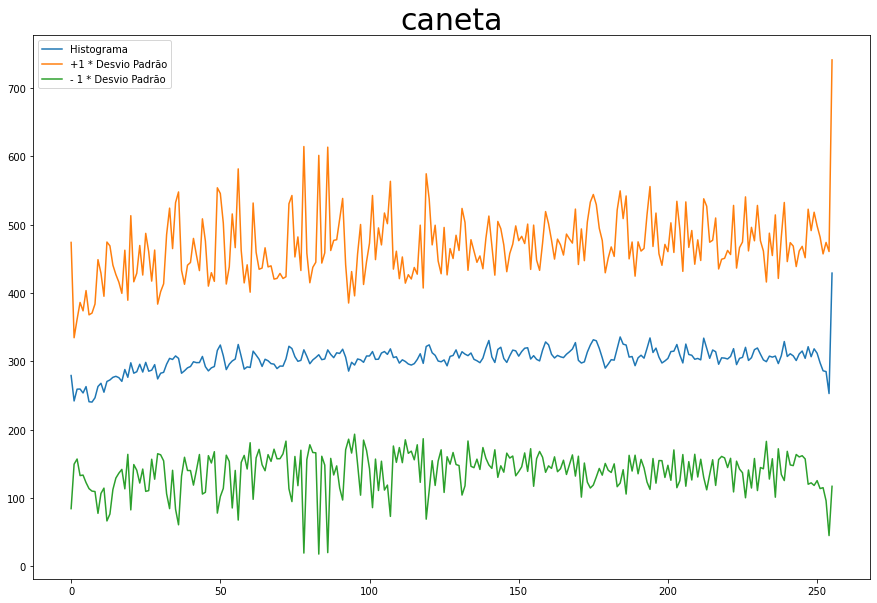

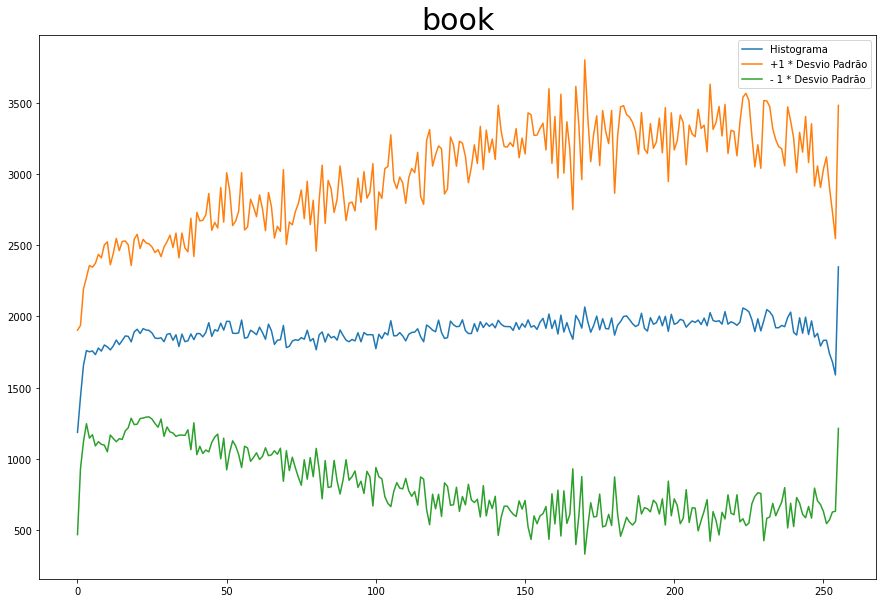

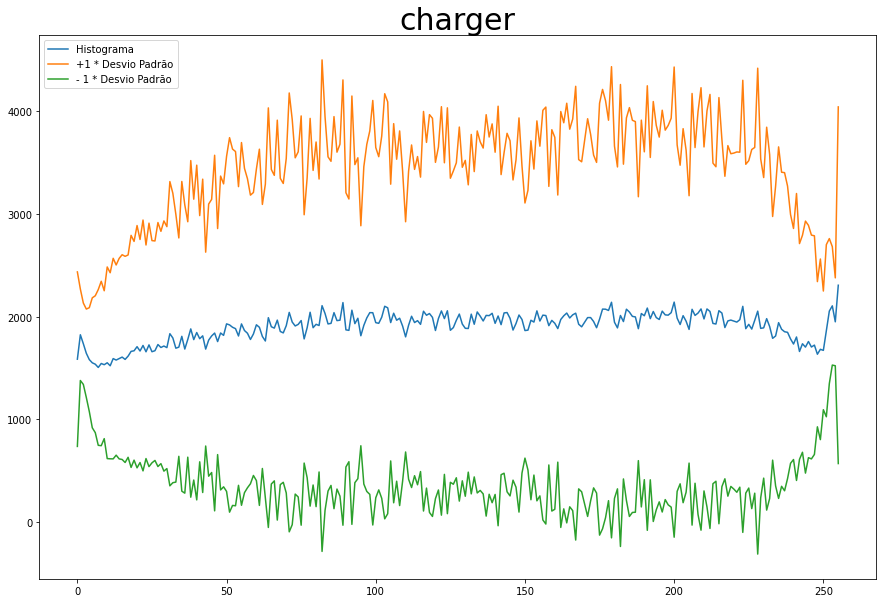

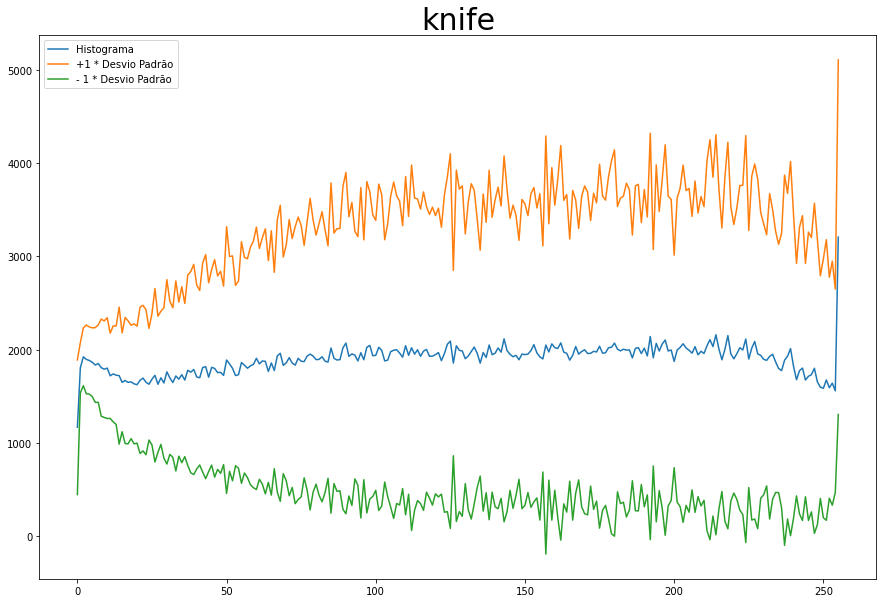

In [ ]:
# Para folder normalizedDataset
for classe in classes:
  histogram, sd = mean_histogram(metadados2, 'normalizedDataset', classe, no_excgrad=True)
  plot_mean_histogram(classe, histogram, sd, sd_mult=1)